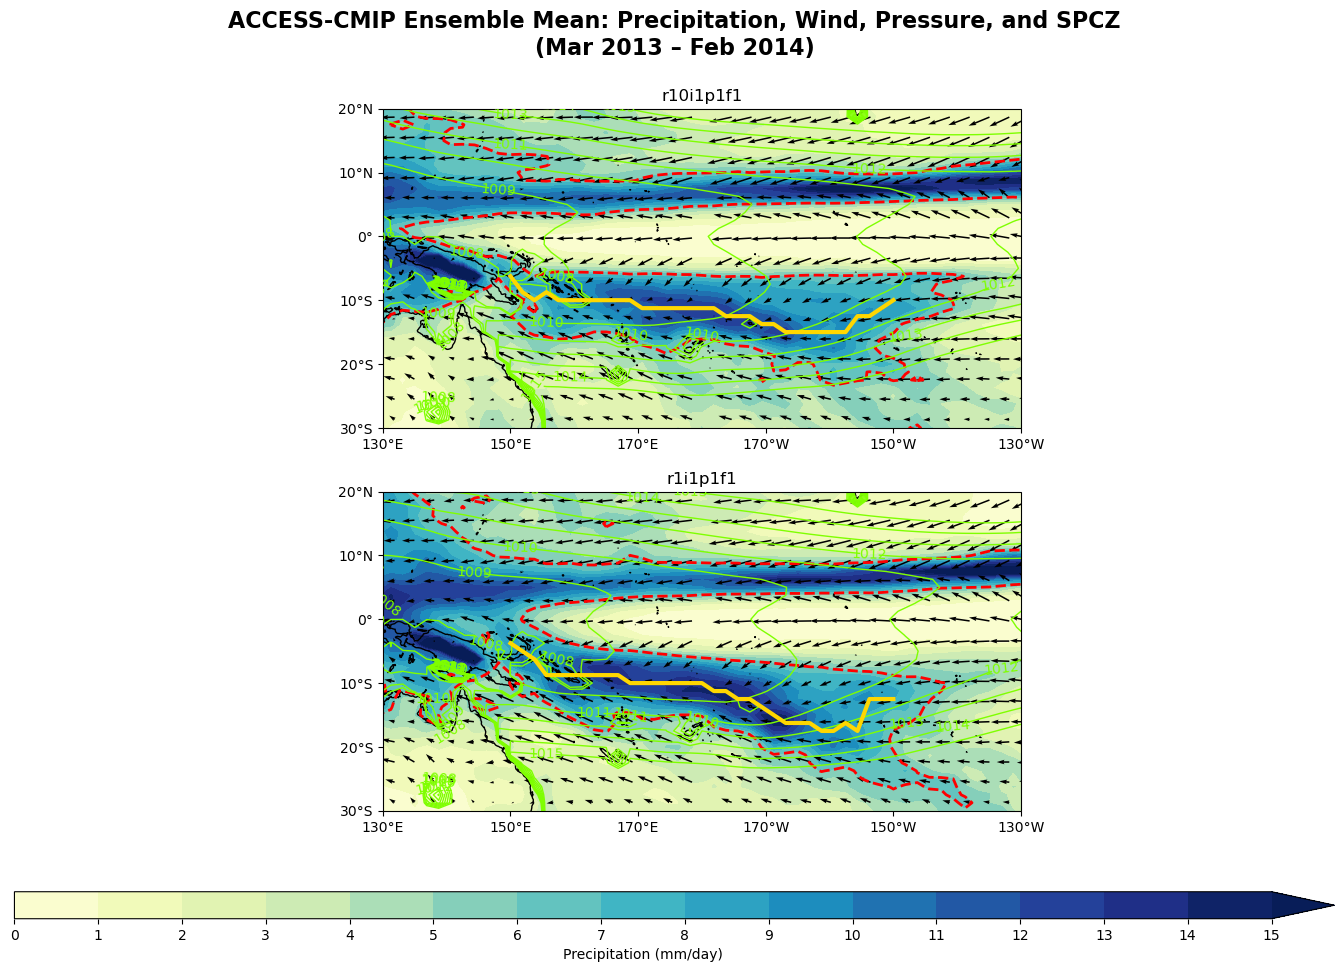

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# File path
cmip_path = '/scratch/nf33/hk25-ConvZones'
cmip_file = 'access_cmip_ensemble_tot_avg.nc'
ds = xr.open_dataset(f"{cmip_path}/{cmip_file}")

# Region selection: 30°S to 20°N and 130°E to 230°E
ds_sel = ds.sel(lat=slice(-35, 25), lon=slice(125, 235))

# Convert variables
pr_mm_day = ds_sel['pr'] * 86400  # mm/day
uas = ds_sel['uas']
vas = ds_sel['vas']
ps = ds_sel['ps'] / 100  # hPa
vec_step = 1

# Runs
runs = ds_sel['run'].values # [:4] # Limit to first 4 runs
n_runs = len(runs)

# Longitude and latitude
lons = ds_sel['lon']
lats = ds_sel['lat']

# Define Precipitation levels
levels = np.arange(0, 16, 1)

# Set up figure
nrows = 2
ncols = int(np.ceil(n_runs / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(22, 9),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.flatten()

for i, run_name in enumerate(runs):
    ax = axs[i]

    # Select data for run
    pr = pr_mm_day.sel(run=run_name)
    u = uas.sel(run=run_name)
    v = vas.sel(run=run_name)
    pressure = ps.sel(run=run_name)

    # Precipitation: filled contour
    cf = ax.contourf(lons, lats, pr, levels=levels, cmap='YlGnBu', extend='max',
                     transform=ccrs.PlateCarree())

    # Add red contour line for 6 mm/day precipitation
    ax.contour(lons, lats, pr, levels=[6], colors='red', linewidths=2, linestyles='--',
           transform=ccrs.PlateCarree())

    # Wind: quiver (subsampled)
    ax.quiver(lons[::vec_step], lats[::vec_step], u[::vec_step, ::vec_step], v[::vec_step, ::vec_step], scale=200, regrid_shape=20,
              transform=ccrs.PlateCarree())

    # Pressure: contour + labels
    cs = ax.contour(lons, lats, pressure, levels=range(1008, 1016, 1), colors='chartreuse', linewidths=1,
                    transform=ccrs.PlateCarree())
    ax.clabel(cs, inline=1, fontsize=10, fmt='%d')

    # SPCZ line (gold): smoothed max precipitation latitude per longitude
    spcz_lon_range = lons.sel(lon=slice(150, 210)).values
    spcz_lat = []

    for lon in spcz_lon_range:
        pr_lon = pr.sel(lon=lon, method='nearest')
        pr_sub = pr_lon.sel(lat=slice(-30, 0))
        pr_smooth = pr_sub.rolling(lat=5, center=True).mean()
        lat_max = pr_smooth.lat[pr_smooth.argmax(dim='lat')].values
        spcz_lat.append(lat_max)

    ax.plot(spcz_lon_range, spcz_lat, color='gold', linewidth=3,
            transform=ccrs.PlateCarree(), label='SPCZ')

    # Map styling
    ax.coastlines()
    ax.set_title(str(run_name))

    # Set custom ticks
    xticks = np.arange(130, 231, 20)  # still in 0–360 format
    yticks = np.arange(-30, 25, 10)
    
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    
    # Format as °E / °W and °N / °S
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°', number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°', number_format='.0f'))

    ax.set_extent([130, 230, -30, 20], crs=ccrs.PlateCarree())

# Shared colorbar
fig.subplots_adjust(bottom=0.1)  # Leave space below plots
cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.03])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax, ticks=levels, orientation='horizontal', label='Precipitation (mm/day)')

# Suptitle
fig.suptitle("ACCESS-CMIP Ensemble Mean: Precipitation, Wind, Pressure, and SPCZ\n(Mar 2013 – Feb 2014)",
             fontsize=16, fontweight='bold', y=0.99)

plt.show()


In [2]:
print(180 in lons.values)
print(lons.sel(lon=180, method='nearest').values)


True
180.0


In [3]:
np.any(np.isnan(uas.sel(run=runs[0])))


<xarray.DataArray 'uas' ()> Size: 1B
array(False)
Coordinates:
    run      <U9 36B 'r10i1p1f1'

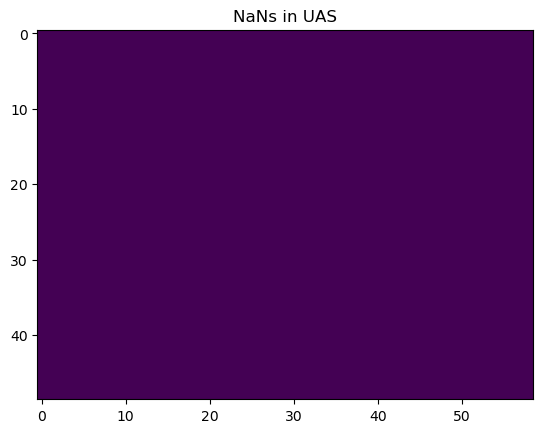

In [4]:
plt.imshow(np.isnan(uas.sel(run=runs[0])), aspect='auto')
plt.title('NaNs in UAS')
plt.show()


In [5]:
u = u.where(~np.isnan(u) & ~np.isnan(v))
v = v.where(~np.isnan(v) & ~np.isnan(u))


In [6]:
lons[::vec_step]

<xarray.DataArray 'lon' (lon: 59)> Size: 472B
array([125.625, 127.5  , 129.375, 131.25 , 133.125, 135.   , 136.875, 138.75 ,
       140.625, 142.5  , 144.375, 146.25 , 148.125, 150.   , 151.875, 153.75 ,
       155.625, 157.5  , 159.375, 161.25 , 163.125, 165.   , 166.875, 168.75 ,
       170.625, 172.5  , 174.375, 176.25 , 178.125, 180.   , 181.875, 183.75 ,
       185.625, 187.5  , 189.375, 191.25 , 193.125, 195.   , 196.875, 198.75 ,
       200.625, 202.5  , 204.375, 206.25 , 208.125, 210.   , 211.875, 213.75 ,
       215.625, 217.5  , 219.375, 221.25 , 223.125, 225.   , 226.875, 228.75 ,
       230.625, 232.5  , 234.375])
Coordinates:
  * lon      (lon) float64 472B 125.6 127.5 129.4 131.2 ... 230.6 232.5 234.4
Attributes:
    bounds:         lon_bnds
    units:          degrees_east
    axis:           X
    long_name:      Longitude
    standard_name:  longitude

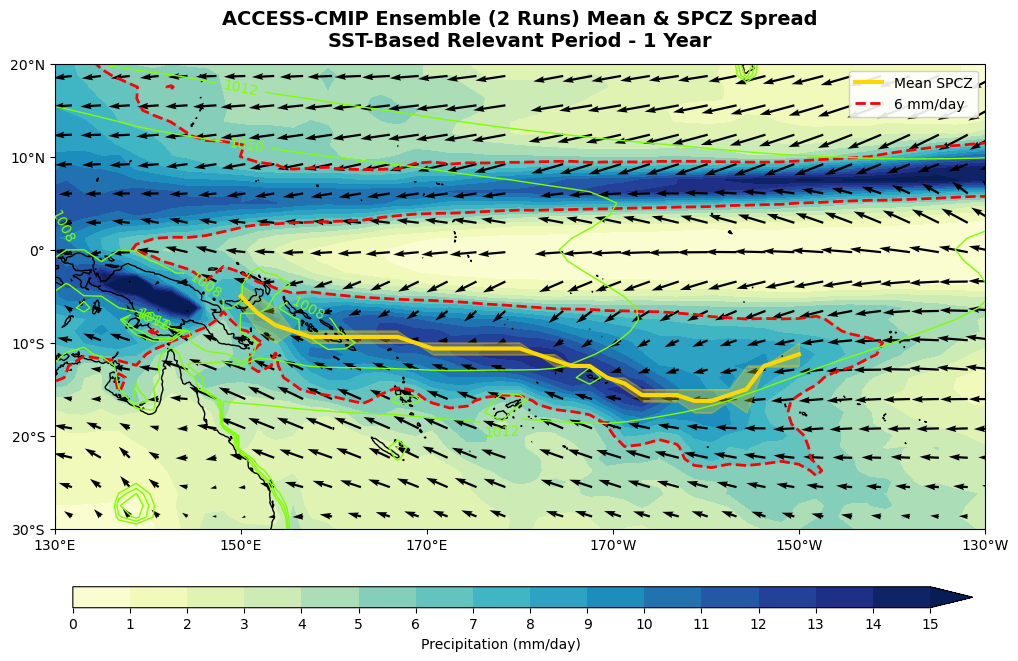

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.lines as mlines

# File path
cmip_path = '/scratch/nf33/hk25-ConvZones'
cmip_file = 'access_cmip_ensemble_tot_avg.nc'
ds = xr.open_dataset(f"{cmip_path}/{cmip_file}")

# Region selection: 30°S to 20°N and 130°E to 230°E
ds_sel = ds.sel(lat=slice(-35, 25), lon=slice(125, 235))

# Convert variables
pr_mm_day = ds_sel['pr'] * 86400  # mm/day
uas = ds_sel['uas']
vas = ds_sel['vas']
ps = ds_sel['ps'] / 100  # hPa
vec_step = 1

# Runs
runs = ds_sel['run'].values # [:4] # Limit to first 4 runs
n_runs = len(runs)

# Longitude and latitude
lons = ds_sel['lon']
lats = ds_sel['lat']

# Define Precipitation levels
levels = np.arange(0, 16, 1)

# Compute ensemble mean fields
pr_mean = pr_mm_day.mean(dim='run')
uas_mean = uas.mean(dim='run')
vas_mean = vas.mean(dim='run')
ps_mean = ps.mean(dim='run')

# Longitude range to compute SPCZ
spcz_lon_range = lons.sel(lon=slice(150, 210)).values
spcz_all = []  # to store per-run SPCZ lines

for run_name in runs:
    pr = pr_mm_day.sel(run=run_name)
    spcz_lat = []

    for lon in spcz_lon_range:
        pr_lon = pr.sel(lon=lon, method='nearest')
        pr_sub = pr_lon.sel(lat=slice(-30, 0))
        pr_smooth = pr_sub.rolling(lat=5, center=True).mean()
        lat_max = pr_smooth.lat[pr_smooth.argmax(dim='lat')].values
        spcz_lat.append(lat_max)

    spcz_all.append(spcz_lat)

spcz_array = np.array(spcz_all)  # shape: (n_runs, n_lons)
spcz_mean = np.mean(spcz_array, axis=0)
spcz_min = np.min(spcz_array, axis=0)
spcz_max = np.max(spcz_array, axis=0)

# Plot single panel
fig, ax = plt.subplots(figsize=(12, 7),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Precipitation contour
cf = ax.contourf(lons, lats, pr_mean, levels=levels, cmap='YlGnBu', extend='max',
                 transform=ccrs.PlateCarree())

# Red contour for 6 mm/day
ax.contour(lons, lats, pr_mean, levels=[6], colors='red', linewidths=2, linestyles='--',
           transform=ccrs.PlateCarree())

# Wind quiver (subsampled)
ax.quiver(lons[::vec_step], lats[::vec_step],
          uas_mean[::vec_step, ::vec_step], vas_mean[::vec_step, ::vec_step],
          scale=200, regrid_shape=20, transform=ccrs.PlateCarree())

# Pressure contours
cs = ax.contour(lons, lats, ps_mean, levels=range(1008, 1014, 2), colors='chartreuse',
                linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(cs, inline=1, fontsize=10, fmt='%d')

# SPCZ lines (each run: semi-transparent gray)
"""for line in spcz_array:
    ax.plot(spcz_lon_range, line, color='gray', linewidth=1, alpha=0.4, transform=ccrs.PlateCarree())"""

# SPCZ spread (min/max envelope)
ax.fill_between(spcz_lon_range, spcz_min, spcz_max, color='gold', alpha=0.3,
                transform=ccrs.PlateCarree())

# Mean SPCZ (bold gold line)
ax.plot(spcz_lon_range, spcz_mean, color='gold', linewidth=3, label='Mean SPCZ',
        transform=ccrs.PlateCarree())

# Styling
ax.coastlines()
ax.set_title("ACCESS-CMIP Ensemble (2 Runs) Mean & SPCZ Spread\nSST-Based Relevant Period - 1 Year", fontsize=14, fontweight='bold', y=1.02)

xticks = np.arange(130, 231, 20)
yticks = np.arange(-30, 25, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°'))
ax.set_extent([130, 230, -30, 20], crs=ccrs.PlateCarree())
# ax.legend(loc='upper right')

# Create a proxy artist for the red dashed contour
red_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='6 mm/day')
handles, labels = ax.get_legend_handles_labels()
handles.append(red_line)
labels.append('6 mm/day')
ax.legend(handles=handles, labels=labels, loc='upper right', framealpha=0.9)


# Add a custom colorbar below the plot
cbar_ax = fig.add_axes([0.14, 0.05, 0.75, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(cf, cax=cbar_ax, ticks=levels, orientation='horizontal', label='Precipitation (mm/day)')

plt.show()
